In [3]:
import cv2
from google.cloud import vision
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import pickle
import os
import matplotlib.pyplot as plt

In [20]:
def load_img_resp(path, file_name):
    img_file = os.path.join(path, 'images', file_name)
    resp_file = os.path.join(path,'resp', f'{os.path.splitext(file_name)[0]}_resp.pkl')
    resp = pickle.load(open(resp_file, 'rb'))
    img = cv2.imread(img_file)
    return img, resp

def show_img(img, size):
    plt.figure(figsize=(size,size))
    plt.axis('off')
    plt.imshow(img[...,::-1])

def get_words(resp):
    valid_words = []
    document = resp.full_text_annotation

    for page in document.pages:
        img_w = page.width
        img_h = page.height
        for block in page.blocks: 
            for para in block.paragraphs: 
                for word in para.words:
                    word = validate_word(word, img_w, img_h)
                    if word != None: valid_words.append(word)
    return valid_words

def validate_word(word, img_w, img_h):
    breaks = vision.TextAnnotation.DetectedBreak.BreakType
    line_break = [breaks.EOL_SURE_SPACE, breaks.LINE_BREAK, breaks.SURE_SPACE]
    word_break = [breaks.SPACE]
    hyphen_break = [breaks.HYPHEN]

    x1 = max(0,word.bounding_box.vertices[0].x)
    y1 = max(0,word.bounding_box.vertices[0].y)
    x2 = min(word.bounding_box.vertices[2].x, img_w)
    y2 = min(word.bounding_box.vertices[2].y, img_h)

    sbb = (x1, y1)
    ebb = (x2, y2)

    text = ''
    for symbol in word.symbols:
        text+=symbol.text
    if text == '': return None

    if word.symbols[-1].property.detected_break.type in line_break:
        break_type = 'line'
    elif word.symbols[-1].property.detected_break.type in word_break:
        break_type = 'word'
    elif word.symbols[-1].property.detected_break.type in hyphen_break:
        break_type = 'hyphen'
    else: break_type = 'none'

    return  {'text': text, 'sbb': sbb, 'ebb': ebb, 'break_type': break_type}

def assign_cluster(centroids, points):
    clusters = []
    for p in points:
        clusters.append(np.absolute(np.array(centroids)-p).argmin())
    return clusters
        
def cluster_columns(words):
    week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    centroids = {}
    points = []

    for word in words:
        x_coord = (word['sbb'][0] + word['ebb'][0])//2
        if word['text'] in week_days: centroids[word['text']] = x_coord
        points.append(x_coord)
    
    cluster_names = list(centroids.keys())
    centroids_values = list(centroids.values())

    assignment = assign_cluster(centroids_values, points)

    clusters = []
    for i in range(len(cluster_names)):
        idx = np.where(np.array(assignment) == i)[0]
        if len(idx)>1:
            cuur_cluster = []
            for j in idx: cuur_cluster.append(words[j])
            clusters.append(cuur_cluster)
    
    return cluster_names, clusters

def sort_clusters(clusters):
    sorted_clusters = []
    for cluster in clusters:
        sorted_cluster = []
        merge_thresh = []
        points = []
        for word in cluster:
            merge_thresh.append(word['ebb'][1]-word['sbb'][1])
            points.append((word['sbb'][1],0))

        merge_thresh = np.mean(merge_thresh)//3

        clustering = AgglomerativeClustering( n_clusters=None, affinity="manhattan", 
                                        linkage="average", distance_threshold=merge_thresh)

        assignment = clustering.fit_predict(points)

        for l in np.unique(assignment):
            idx = np.where(assignment==l)[0]
            if len(idx)>0:
                elements = []
                for i in idx:
                    elements.append(cluster[i])
                elements.sort(key=lambda x: x['sbb'][0])
                sorted_cluster.append(elements)
        
        sorted_cluster.sort(key=lambda  x: x[0]['sbb'][1])
        sorted_clusters.append(parse_day(sorted_cluster))
    
    return sorted_clusters

def parse_day(day):
    text_l = []
    space_less_chars = ['-', ':']
    for row in day:
        for word in row:
            w = word['text']
            if w[0] in space_less_chars:
                text_l.pop()
            if word['break_type']=='hyphen':
                w+='-' 
            text_l.append(w)
            if w[-1] not in space_less_chars:
                text_l.append(" ")    
    text=""
    for t in text_l: text+=t
    return text

def split_events(week):
    event_split_week = []
    for day in week:
        words = day.split()
        day_name = words[0]
        all_events = words[1:]
        if len(all_events) % 9 != 0:
            print("Failed to extract some events")
            continue
        else:
            n = 9
            events = [all_events[i * n:(i + 1) * n] for i in range((len(all_events) + n - 1) // n )]
        event_split_week.append({'day': day_name, 'events': events})
    return event_split_week

def parse_time(time_str):
    t = time_str.split('-')
    start = format_time(t[0])
    end = format_time(t[1])
    return start, end

def format_time(time):
    meridiem = time[-2:].lower()
    time = time[:-2]

    if meridiem == 'am' and time[:2] == '12':
        return '00'+time[2:]
    elif meridiem == 'am':
        return time
    elif meridiem == 'pm' and time[:2] == '12':
        return time
    else:
        time = time.split(':')
        h = str(int(time[0])+12)
        return h+":"+time[1]
    
def format_events(week):
    events = []
    for d in week:
        for event in d['events']:
            day = d['day']
            course = event[0]+" "+event[1]
            loc = event[-2]+" "+event[-1]
            s_time, e_time = parse_time(""+event[4]+event[5]+event[6])
            events.append({'day': day, 'class': course, 'start_time': s_time, 'end_time': e_time, 'location': loc})
    return events


Failed to extract some events
Failed to extract some events


[{'day': 'Tuesday',
  'class': 'ITCS 6100-001',
  'start_time': '8:30',
  'end_time': '9:45',
  'location': 'CARC 101'},
 {'day': 'Tuesday',
  'class': 'ITCS 6112-091',
  'start_time': '19:00',
  'end_time': '21:45',
  'location': 'WOODW 106'}]

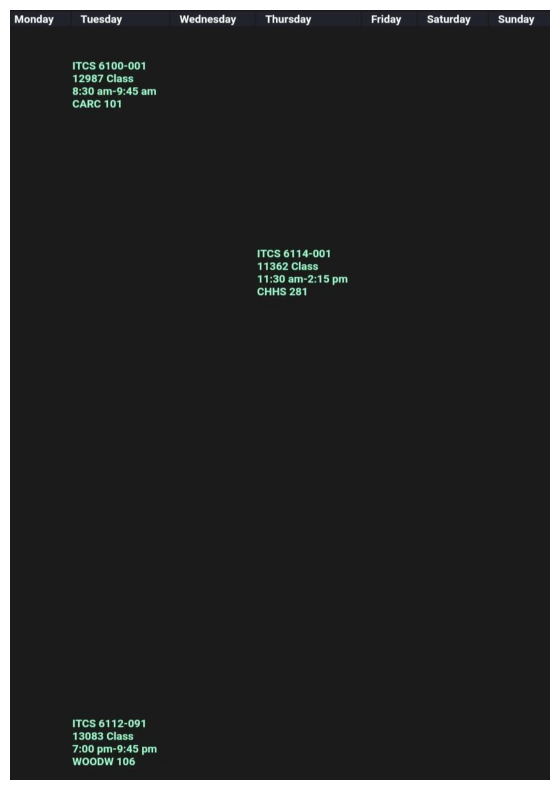

In [21]:
data_path = 'data'
img, resp = load_img_resp(data_path, 'image_3.jpg')
words = get_words(resp)
cluster_names, clusters = cluster_columns(words)
sorted_clusters = sort_clusters(clusters)

week = split_events(sorted_clusters)
events = format_events(week)

show_img(img, 10)
events